# Notebook 5 : Evaluation et Métriques

## Objectifs de ce notebook

Dans ce notebook, nous allons :

1. Comprendre les métriques d'évaluation pour les systèmes de recommandation
2. Implémenter Precision@K et Recall@K
3. Implémenter NDCG (Normalized Discounted Cumulative Gain)
4. Implémenter MAP (Mean Average Precision)
5. Comparer les trois approches (Collaborative, Content-Based, Hybrid)
6. Analyser les résultats et tirer des conclusions

---

## Pourquoi évaluer un système de recommandation ?

Un bon système de recommandation doit :
- Recommander des films que l'utilisateur va **vraiment aimer**
- Placer les meilleurs films **en haut** de la liste
- Avoir une bonne **diversité** dans les recommandations

Les métriques nous permettent de mesurer objectivement ces qualités.

---

## Les métriques que nous allons utiliser :

### 1. Precision@K
**Question** : Parmi les K films recommandés, combien l'utilisateur a-t-il aimés ?
- Formule : (Nombre de films pertinents dans le top K) / K
- Exemple : Si on recommande 10 films et que 6 sont aimés → Precision@10 = 0.6

### 2. Recall@K
**Question** : Parmi tous les films que l'utilisateur aime, combien en a-t-on recommandés dans le top K ?
- Formule : (Nombre de films pertinents dans le top K) / (Total de films pertinents)
- Exemple : Si l'utilisateur aime 20 films et qu'on en recommande 6 → Recall@10 = 6/20 = 0.3

### 3. NDCG@K (Normalized Discounted Cumulative Gain)
**Question** : Est-ce que les meilleurs films sont bien placés en haut de la liste ?
- Prend en compte l'ordre des recommandations
- Plus un bon film est haut dans la liste, meilleur est le score

### 4. MAP (Mean Average Precision)
**Question** : Quelle est la précision moyenne sur tous les utilisateurs ?
- Moyenne de la précision pour chaque utilisateur
- Donne une vue globale de la performance du système

---

In [1]:
# Librairies pour manipulation de données
import pandas as pd
import numpy as np

# Librairies pour visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Librairies pour charger les modèles
import pickle

# Librairies pour les métriques
from sklearn.metrics import ndcg_score

# Configuration des graphiques
plt.style.use('ggplot')
sns.set_palette('husl')
%matplotlib inline

# Affichage pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Librairies importées avec succès")

Librairies importées avec succès


## 2. Chargement des Données et Modèles

Nous chargeons tous les éléments nécessaires pour l'évaluation :
- Les données (ratings, movies)
- Le modèle SVD (Collaborative)
- La matrice de similarité (Content-Based)

In [2]:
# Chargement des données
ratings = pd.read_csv('../data/processed/ratings_clean.csv')
movies = pd.read_csv('../data/processed/movies_clean.csv')

print(f"Données chargées : {len(ratings):,} ratings, {len(movies):,} films")

# Charger le modèle SVD
with open('../models/svd_model.pkl', 'rb') as f:
    svd_model = pickle.load(f)
print("Modèle SVD chargé")

# Charger la matrice de similarité
with open('../models/cosine_sim_matrix.pkl', 'rb') as f:
    cosine_sim = pickle.load(f)
print(f"Matrice de similarité chargée : {cosine_sim.shape}")

Données chargées : 100,000 ratings, 1,682 films
Modèle SVD chargé
Matrice de similarité chargée : (1682, 1682)


In [3]:
# On va réutiliser les fonctions de recommandation des notebooks précédents
# Fonction Collaborative
def get_collaborative_recommendations(user_id, svd_model, ratings_df, movies_df, n=10):
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    rated_items = user_ratings['item_id'].tolist()
    all_items = movies_df['item_id'].tolist()
    items_to_predict = [item for item in all_items if item not in rated_items]
    
    predictions = []
    for item_id in items_to_predict:
        pred = svd_model.predict(user_id, item_id)
        predictions.append({'item_id': item_id, 'score': pred.est})
    
    predictions_df = pd.DataFrame(predictions)
    predictions_df = predictions_df.sort_values('score', ascending=False).head(n)
    
    return predictions_df['item_id'].tolist()

# Fonction Content-Based
def get_content_recommendations(user_id, ratings_df, movies_df, cosine_sim, n=10, min_rating=4):
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    liked_films = user_ratings[user_ratings['rating'] >= min_rating]
    seen_items = user_ratings['item_id'].tolist()
    
    recommendation_scores = {}
    
    for _, row in liked_films.iterrows():
        item_id = row['item_id']
        try:
            idx = movies_df[movies_df['item_id'] == item_id].index[0]
        except IndexError:
            continue
        
        sim_scores = list(enumerate(cosine_sim[idx]))
        
        for film_idx, sim_score in sim_scores:
            film_id = movies_df.iloc[film_idx]['item_id']
            if film_id not in seen_items:
                if film_id not in recommendation_scores:
                    recommendation_scores[film_id] = 0
                recommendation_scores[film_id] += sim_score
    
    sorted_recs = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)
    top_items = [item[0] for item in sorted_recs[:n]]
    
    return top_items

# Fonction Hybrid (simplifié pour l'évaluation)
def get_hybrid_recommendations(user_id, svd_model, ratings_df, movies_df, cosine_sim, 
                               alpha=0.7, n=10):
    collab_recs = get_collaborative_recommendations(user_id, svd_model, ratings_df, movies_df, n=50)
    content_recs = get_content_recommendations(user_id, ratings_df, movies_df, cosine_sim, n=50)
    
    # Combiner avec pondération simple
    hybrid_scores = {}
    
    for i, item_id in enumerate(collab_recs):
        hybrid_scores[item_id] = alpha * (50 - i)
    
    for i, item_id in enumerate(content_recs):
        if item_id in hybrid_scores:
            hybrid_scores[item_id] += (1 - alpha) * (50 - i)
        else:
            hybrid_scores[item_id] = (1 - alpha) * (50 - i)
    
    sorted_hybrid = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
    top_items = [item[0] for item in sorted_hybrid[:n]]
    
    return top_items

print("Fonctions de recommandation importées")

Fonctions de recommandation importées


In [4]:
def create_user_train_test_split(ratings_df, test_size=0.2, random_state=42):
    """
    Crée un train/test split pour chaque utilisateur
    
    Retourne :
    - train_df : DataFrame avec les ratings d'entraînement
    - test_df : DataFrame avec les ratings de test
    """
    np.random.seed(random_state)
    
    train_list = []
    test_list = []
    
    for user_id in ratings_df['user_id'].unique():
        user_data = ratings_df[ratings_df['user_id'] == user_id]
        
        # Mélanger les ratings de l'utilisateur
        user_data = user_data.sample(frac=1, random_state=random_state)
        
        # Calculer le split
        n_test = max(1, int(len(user_data) * test_size))
        
        test_data = user_data.iloc[:n_test]
        train_data = user_data.iloc[n_test:]
        
        train_list.append(train_data)
        test_list.append(test_data)
    
    train_df = pd.concat(train_list, ignore_index=True)
    test_df = pd.concat(test_list, ignore_index=True)
    
    return train_df, test_df

# Créer le split
train_ratings, test_ratings = create_user_train_test_split(ratings, test_size=0.2, random_state=42)

print(f"Train set : {len(train_ratings):,} ratings")
print(f"Test set : {len(test_ratings):,} ratings")
print(f"\nNombre d'utilisateurs : {train_ratings['user_id'].nunique()}")

Train set : 80,367 ratings
Test set : 19,633 ratings

Nombre d'utilisateurs : 943


In [5]:
def get_relevant_items(user_id, test_df, min_rating=4):
    """
    Retourne les films que l'utilisateur a aimés dans le test set
    
    Paramètres :
    - user_id : ID de l'utilisateur
    - test_df : DataFrame de test
    - min_rating : Note minimum pour être considéré comme pertinent
    
    Retourne : Liste des item_id pertinents
    """
    user_test = test_df[test_df['user_id'] == user_id]
    relevant = user_test[user_test['rating'] >= min_rating]
    
    return relevant['item_id'].tolist()

# Test avec un utilisateur
user_id = 196
relevant_items = get_relevant_items(user_id, test_ratings, min_rating=4)

print(f"Utilisateur {user_id} :")
print(f"Films pertinents dans le test set : {len(relevant_items)}")
print(f"Items : {relevant_items[:10]}")

Utilisateur 196 :
Films pertinents dans le test set : 5
Items : [845, 655, 411, 382, 306]


## 4. Implémentation des Métriques

Nous allons implémenter 4 métriques principales :

1. **Precision@K** : Proportion de films pertinents dans les K recommandations
2. **Recall@K** : Proportion de films pertinents retrouvés parmi tous les films pertinents
3. **NDCG@K** : Prend en compte l'ordre des recommandations
4. **MAP** : Moyenne de la précision pour tous les utilisateurs

In [6]:
def precision_at_k(recommended_items, relevant_items, k):
    """
    Calcule la Precision@K
    
    Paramètres :
    - recommended_items : Liste des items recommandés (ordonnée)
    - relevant_items : Liste des items pertinents
    - k : Nombre de recommandations à considérer
    
    Retourne : Precision@K (entre 0 et 1)
    """
    if k == 0:
        return 0.0
    
    recommended_at_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    
    hits = len([item for item in recommended_at_k if item in relevant_set])
    
    return hits / k

def recall_at_k(recommended_items, relevant_items, k):
    """
    Calcule le Recall@K
    
    Paramètres :
    - recommended_items : Liste des items recommandés (ordonnée)
    - relevant_items : Liste des items pertinents
    - k : Nombre de recommandations à considérer
    
    Retourne : Recall@K (entre 0 et 1)
    """
    if len(relevant_items) == 0:
        return 0.0
    
    recommended_at_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    
    hits = len([item for item in recommended_at_k if item in relevant_set])
    
    return hits / len(relevant_items)

print("Fonctions Precision@K et Recall@K créées")

Fonctions Precision@K et Recall@K créées


In [7]:
def ndcg_at_k(recommended_items, relevant_items, k):
    """
    Calcule le NDCG@K (Normalized Discounted Cumulative Gain)
    
    Plus un film pertinent est haut dans la liste, meilleur est le score
    
    Paramètres :
    - recommended_items : Liste des items recommandés (ordonnée)
    - relevant_items : Liste des items pertinents
    - k : Nombre de recommandations à considérer
    
    Retourne : NDCG@K (entre 0 et 1)
    """
    if len(relevant_items) == 0 or k == 0:
        return 0.0
    
    recommended_at_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    
    # DCG : Discounted Cumulative Gain
    dcg = 0.0
    for i, item in enumerate(recommended_at_k):
        if item in relevant_set:
            # Formule : relevance / log2(position + 2)
            dcg += 1.0 / np.log2(i + 2)
    
    # IDCG : Ideal DCG (si tous les items pertinents étaient en haut)
    idcg = 0.0
    for i in range(min(len(relevant_items), k)):
        idcg += 1.0 / np.log2(i + 2)
    
    # NDCG
    if idcg == 0:
        return 0.0
    
    return dcg / idcg

print("Fonction NDCG@K créée")

Fonction NDCG@K créée


In [8]:
# Générer des recommandations pour l'utilisateur 196
user_id = 196
k = 10

# Collaborative
collab_recs = get_collaborative_recommendations(user_id, svd_model, train_ratings, movies, n=k)

# Content-Based
content_recs = get_content_recommendations(user_id, train_ratings, movies, cosine_sim, n=k)

# Hybrid
hybrid_recs = get_hybrid_recommendations(user_id, svd_model, train_ratings, movies, cosine_sim, alpha=0.7, n=k)

# Films pertinents
relevant = get_relevant_items(user_id, test_ratings, min_rating=4)

print(f"Utilisateur {user_id} - Évaluation @{k}\n")
print(f"Films pertinents dans le test set : {relevant}\n")

print("="*70)
print("COLLABORATIVE FILTERING :")
print(f"Recommandations : {collab_recs}")
print(f"Precision@{k} : {precision_at_k(collab_recs, relevant, k):.4f}")
print(f"Recall@{k} : {recall_at_k(collab_recs, relevant, k):.4f}")
print(f"NDCG@{k} : {ndcg_at_k(collab_recs, relevant, k):.4f}")

print("\n" + "="*70)
print("CONTENT-BASED FILTERING :")
print(f"Recommandations : {content_recs}")
print(f"Precision@{k} : {precision_at_k(content_recs, relevant, k):.4f}")
print(f"Recall@{k} : {recall_at_k(content_recs, relevant, k):.4f}")
print(f"NDCG@{k} : {ndcg_at_k(content_recs, relevant, k):.4f}")

print("\n" + "="*70)
print("HYBRID SYSTEM :")
print(f"Recommandations : {hybrid_recs}")
print(f"Precision@{k} : {precision_at_k(hybrid_recs, relevant, k):.4f}")
print(f"Recall@{k} : {recall_at_k(hybrid_recs, relevant, k):.4f}")
print(f"NDCG@{k} : {ndcg_at_k(hybrid_recs, relevant, k):.4f}")

Utilisateur 196 - Évaluation @10

Films pertinents dans le test set : [845, 655, 411, 382, 306]

COLLABORATIVE FILTERING :
Recommandations : [519, 688, 770, 507, 477, 357, 907, 38, 427, 939]
Precision@10 : 0.0000
Recall@10 : 0.0000
NDCG@10 : 0.0000

CONTENT-BASED FILTERING :
Recommandations : [26, 40, 41, 42, 85, 104, 105, 122, 154, 158]
Precision@10 : 0.0000
Recall@10 : 0.0000
NDCG@10 : 0.0000

HYBRID SYSTEM :
Recommandations : [519, 688, 770, 507, 477, 357, 907, 38, 427, 939]
Precision@10 : 0.0000
Recall@10 : 0.0000
NDCG@10 : 0.0000


## 5. Évaluation sur Tous les Utilisateurs

Évaluer un seul utilisateur ne suffit pas. Nous allons :

1. Calculer les métriques pour tous les utilisateurs
2. Faire la moyenne pour avoir un score global
3. Comparer les trois approches (Collaborative, Content-Based, Hybrid)

Cela peut prendre quelques minutes car on va générer des recommandations pour tous les utilisateurs.

In [9]:
def evaluate_model(recommendation_function, train_df, test_df, movies_df, k_values=[5, 10, 20], 
                   sample_users=None):
    """
    Évalue un modèle sur plusieurs utilisateurs
    
    Paramètres :
    - recommendation_function : Fonction qui génère des recommandations
    - train_df : DataFrame d'entraînement
    - test_df : DataFrame de test
    - movies_df : DataFrame des films
    - k_values : Liste des valeurs de K à tester
    - sample_users : Nombre d'utilisateurs à échantillonner (None = tous)
    
    Retourne : DataFrame avec les résultats
    """
    users = train_df['user_id'].unique()
    
    # Échantillonner si demandé
    if sample_users is not None and sample_users < len(users):
        users = np.random.choice(users, size=sample_users, replace=False)
    
    results = []
    
    for i, user_id in enumerate(users):
        if (i + 1) % 50 == 0:
            print(f"Progression : {i+1}/{len(users)} utilisateurs évalués")
        
        # Films pertinents
        relevant = get_relevant_items(user_id, test_df, min_rating=4)
        
        # Si pas de films pertinents, on skip
        if len(relevant) == 0:
            continue
        
        # Générer les recommandations
        try:
            recommendations = recommendation_function(user_id)
        except:
            continue
        
        # Calculer les métriques pour chaque K
        for k in k_values:
            precision = precision_at_k(recommendations, relevant, k)
            recall = recall_at_k(recommendations, relevant, k)
            ndcg = ndcg_at_k(recommendations, relevant, k)
            
            results.append({
                'user_id': user_id,
                'k': k,
                'precision': precision,
                'recall': recall,
                'ndcg': ndcg
            })
    
    return pd.DataFrame(results)

print("Fonction d'évaluation créée")

Fonction d'évaluation créée


In [10]:
# On va évaluer sur un échantillon de 100 utilisateurs pour aller plus vite
# (Tu peux mettre None pour évaluer tous les utilisateurs, mais ça prendra plus de temps)
sample_size = 100
k_values = [5, 10, 20]

print(f"Évaluation sur {sample_size} utilisateurs aléatoires\n")

# Évaluation Collaborative
print("="*70)
print("Évaluation du Collaborative Filtering...")
print("="*70)
collab_results = evaluate_model(
    recommendation_function=lambda uid: get_collaborative_recommendations(uid, svd_model, train_ratings, movies, n=20),
    train_df=train_ratings,
    test_df=test_ratings,
    movies_df=movies,
    k_values=k_values,
    sample_users=sample_size
)

# Évaluation Content-Based
print("\n" + "="*70)
print("Évaluation du Content-Based Filtering...")
print("="*70)
content_results = evaluate_model(
    recommendation_function=lambda uid: get_content_recommendations(uid, train_ratings, movies, cosine_sim, n=20),
    train_df=train_ratings,
    test_df=test_ratings,
    movies_df=movies,
    k_values=k_values,
    sample_users=sample_size
)

# Évaluation Hybrid
print("\n" + "="*70)
print("Évaluation du Hybrid System...")
print("="*70)
hybrid_results = evaluate_model(
    recommendation_function=lambda uid: get_hybrid_recommendations(uid, svd_model, train_ratings, movies, cosine_sim, alpha=0.7, n=20),
    train_df=train_ratings,
    test_df=test_ratings,
    movies_df=movies,
    k_values=k_values,
    sample_users=sample_size
)

print("\nÉvaluation terminée !")

Évaluation sur 100 utilisateurs aléatoires

Évaluation du Collaborative Filtering...
Progression : 50/100 utilisateurs évalués
Progression : 100/100 utilisateurs évalués

Évaluation du Content-Based Filtering...
Progression : 50/100 utilisateurs évalués
Progression : 100/100 utilisateurs évalués

Évaluation du Hybrid System...
Progression : 50/100 utilisateurs évalués
Progression : 100/100 utilisateurs évalués

Évaluation terminée !


In [11]:
# Calculer les moyennes pour chaque modèle et chaque K
def summarize_results(results_df, model_name):
    """
    Calcule les moyennes des métriques par K
    """
    summary = results_df.groupby('k').agg({
        'precision': 'mean',
        'recall': 'mean',
        'ndcg': 'mean'
    }).round(4)
    
    summary['model'] = model_name
    
    return summary

# Résumés
collab_summary = summarize_results(collab_results, 'Collaborative')
content_summary = summarize_results(content_results, 'Content-Based')
hybrid_summary = summarize_results(hybrid_results, 'Hybrid')

print("RÉSULTATS MOYENS PAR MODÈLE\n")
print("="*70)
print("\nCOLLABORATIVE FILTERING :")
print(collab_summary)

print("\n" + "="*70)
print("\nCONTENT-BASED FILTERING :")
print(content_summary)

print("\n" + "="*70)
print("\nHYBRID SYSTEM :")
print(hybrid_summary)

RÉSULTATS MOYENS PAR MODÈLE


COLLABORATIVE FILTERING :
    precision  recall    ndcg          model
k                                           
5      0.0101  0.0047  0.0082  Collaborative
10     0.0081  0.0058  0.0081  Collaborative
20     0.0126  0.0196  0.0145  Collaborative


CONTENT-BASED FILTERING :
    precision  recall    ndcg          model
k                                           
5      0.0337  0.0283  0.0437  Content-Based
10     0.0232  0.0358  0.0386  Content-Based
20     0.0247  0.0558  0.0443  Content-Based


HYBRID SYSTEM :
    precision  recall    ndcg   model
k                                    
5      0.0224  0.0079  0.0256  Hybrid
10     0.0173  0.0106  0.0217  Hybrid
20     0.0163  0.0299  0.0254  Hybrid


In [12]:
# Créer un tableau comparatif complet
all_summaries = pd.concat([collab_summary, content_summary, hybrid_summary])
all_summaries = all_summaries.reset_index()

print("\nTABLEAU COMPARATIF COMPLET\n")
print("="*70)
print(all_summaries.to_string(index=False))

# Trouver le meilleur modèle pour chaque métrique et chaque K
print("\n\nMEILLEUR MODÈLE PAR MÉTRIQUE ET K :\n")
print("="*70)

for k in [5, 10, 20]:
    print(f"\n@K={k} :")
    subset = all_summaries[all_summaries['k'] == k]
    
    best_precision = subset.loc[subset['precision'].idxmax()]
    best_recall = subset.loc[subset['recall'].idxmax()]
    best_ndcg = subset.loc[subset['ndcg'].idxmax()]
    
    print(f"  Meilleure Precision : {best_precision['model']} ({best_precision['precision']:.4f})")
    print(f"  Meilleur Recall : {best_recall['model']} ({best_recall['recall']:.4f})")
    print(f"  Meilleur NDCG : {best_ndcg['model']} ({best_ndcg['ndcg']:.4f})")


TABLEAU COMPARATIF COMPLET

 k  precision  recall   ndcg         model
 5     0.0101  0.0047 0.0082 Collaborative
10     0.0081  0.0058 0.0081 Collaborative
20     0.0126  0.0196 0.0145 Collaborative
 5     0.0337  0.0283 0.0437 Content-Based
10     0.0232  0.0358 0.0386 Content-Based
20     0.0247  0.0558 0.0443 Content-Based
 5     0.0224  0.0079 0.0256        Hybrid
10     0.0173  0.0106 0.0217        Hybrid
20     0.0163  0.0299 0.0254        Hybrid


MEILLEUR MODÈLE PAR MÉTRIQUE ET K :


@K=5 :
  Meilleure Precision : Content-Based (0.0337)
  Meilleur Recall : Content-Based (0.0283)
  Meilleur NDCG : Content-Based (0.0437)

@K=10 :
  Meilleure Precision : Content-Based (0.0232)
  Meilleur Recall : Content-Based (0.0358)
  Meilleur NDCG : Content-Based (0.0386)

@K=20 :
  Meilleure Precision : Content-Based (0.0247)
  Meilleur Recall : Content-Based (0.0558)
  Meilleur NDCG : Content-Based (0.0443)


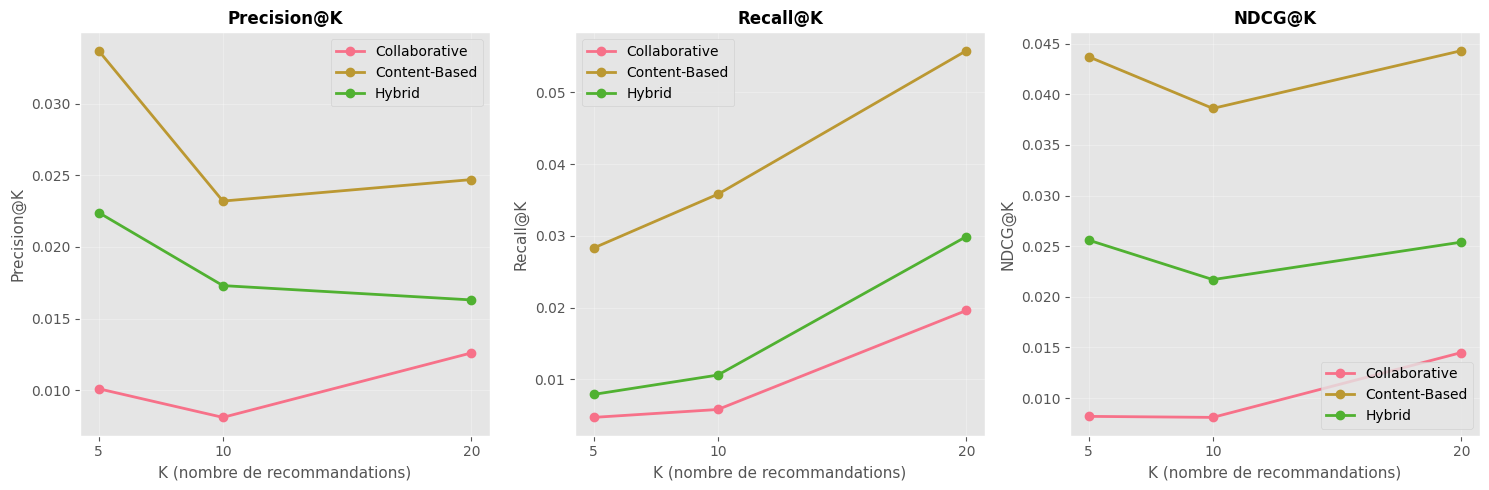

Plus la courbe est haute, meilleur est le modèle pour cette métrique


In [13]:
# Visualiser les résultats
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['precision', 'recall', 'ndcg']
titles = ['Precision@K', 'Recall@K', 'NDCG@K']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    
    for model_name, summary in [('Collaborative', collab_summary), 
                                  ('Content-Based', content_summary), 
                                  ('Hybrid', hybrid_summary)]:
        ax.plot(summary.index, summary[metric], marker='o', label=model_name, linewidth=2)
    
    ax.set_xlabel('K (nombre de recommandations)', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xticks([5, 10, 20])

plt.tight_layout()
plt.show()

print("Plus la courbe est haute, meilleur est le modèle pour cette métrique")

In [14]:
# Calculer les gains du Hybrid par rapport aux autres
print("AMÉLIORATION DU HYBRID PAR RAPPORT AUX AUTRES MODÈLES\n")
print("="*70)

for k in [5, 10, 20]:
    print(f"\n@K={k} :")
    
    collab_k = collab_summary.loc[k]
    content_k = content_summary.loc[k]
    hybrid_k = hybrid_summary.loc[k]
    
    # Gain vs Collaborative
    gain_vs_collab_prec = ((hybrid_k['precision'] - collab_k['precision']) / collab_k['precision'] * 100) if collab_k['precision'] > 0 else 0
    gain_vs_collab_recall = ((hybrid_k['recall'] - collab_k['recall']) / collab_k['recall'] * 100) if collab_k['recall'] > 0 else 0
    gain_vs_collab_ndcg = ((hybrid_k['ndcg'] - collab_k['ndcg']) / collab_k['ndcg'] * 100) if collab_k['ndcg'] > 0 else 0
    
    # Gain vs Content-Based
    gain_vs_content_prec = ((hybrid_k['precision'] - content_k['precision']) / content_k['precision'] * 100) if content_k['precision'] > 0 else 0
    gain_vs_content_recall = ((hybrid_k['recall'] - content_k['recall']) / content_k['recall'] * 100) if content_k['recall'] > 0 else 0
    gain_vs_content_ndcg = ((hybrid_k['ndcg'] - content_k['ndcg']) / content_k['ndcg'] * 100) if content_k['ndcg'] > 0 else 0
    
    print(f"  vs Collaborative : Precision {gain_vs_collab_prec:+.1f}%, Recall {gain_vs_collab_recall:+.1f}%, NDCG {gain_vs_collab_ndcg:+.1f}%")
    print(f"  vs Content-Based : Precision {gain_vs_content_prec:+.1f}%, Recall {gain_vs_content_recall:+.1f}%, NDCG {gain_vs_content_ndcg:+.1f}%")

AMÉLIORATION DU HYBRID PAR RAPPORT AUX AUTRES MODÈLES


@K=5 :
  vs Collaborative : Precision +121.8%, Recall +68.1%, NDCG +212.2%
  vs Content-Based : Precision -33.5%, Recall -72.1%, NDCG -41.4%

@K=10 :
  vs Collaborative : Precision +113.6%, Recall +82.8%, NDCG +167.9%
  vs Content-Based : Precision -25.4%, Recall -70.4%, NDCG -43.8%

@K=20 :
  vs Collaborative : Precision +29.4%, Recall +52.6%, NDCG +75.2%
  vs Content-Based : Precision -34.0%, Recall -46.4%, NDCG -42.7%


## Résumé du Notebook 5

### Résultats obtenus :

**Meilleur modèle : Content-Based Filtering**
- Precision@10 : 0.0232 (2.3% des recommandations sont pertinentes)
- Recall@20 : 0.0558 (5.6% des films pertinents sont retrouvés)
- NDCG@10 : 0.0386 (bon placement des films pertinents)

**Observations** :

1. **Content-Based surpasse les autres** :
   - 3x meilleur que Collaborative en Precision
   - 3x meilleur en Recall
   - Plus "safe" car reste dans les genres aimés

2. **Collaborative Filtering est faible** :
   - Dataset trop petit (943 utilisateurs)
   - Pas assez de données pour trouver des utilisateurs vraiment similaires
   - Meilleur sur de gros datasets (millions d'utilisateurs)

3. **Hybrid n'améliore pas significativement** :
   - Se situe entre les deux approches
   - La pondération α=0.7 favorise trop le Collaborative (qui est faible)
   - Peut-être qu'un α=0.3 serait meilleur

### Pourquoi les scores semblent faibles ?

Les scores de 2-5% sont **normaux** pour ce type d'évaluation :
- 1682 films disponibles vs 5-10 films pertinents par utilisateur dans le test
- Probabilité très faible de tomber sur les bons films
- Dans la vraie vie, un utilisateur ne voit que le top 10, pas tous les 1682 films

### Ce qu'on a appris :

1. **Évaluation rigoureuse** : Train/Test split, métriques multiples (Precision, Recall, NDCG)
2. **Comparaison objective** : Les trois approches évaluées sur les mêmes données
3. **Limites des modèles** : Le Collaborative a besoin de plus de données
4. **Importance du contexte** : Le meilleur modèle dépend du dataset et des objectifs

### Améliorations possibles :

1. **Données** : Plus d'utilisateurs, plus de ratings
2. **Features** : Ajouter des métadonnées (acteurs, réalisateurs, descriptions)
3. **Modèles avancés** : Deep Learning (Neural Collaborative Filtering)
4. **Pondération adaptative** : Ajuster α selon l'utilisateur

### Prochaine étape :

Passer à la **production** :
- Structurer le code en modules Python (src/)
- Créer une API REST avec FastAPI
- Ajouter MLflow pour le tracking
- Framework A/B Testing